In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
df = pd.read_csv(r'C:\Users\Home\csv_files\train_1.csv')

In [3]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


> - Each row corresponds to a particular article and each column corresponds to a particular date.  
> - The values are the number of visits on that date.  
> - The page name contains data in this format: SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

In [4]:
import re
page_language = df.Page.apply(lambda row : row.split('wikipedia')[0][-3:-1])
df.insert(loc=1, column='language', value=page_language) 
df.language.unique()

array(['zh', 'fr', 'en', 'de', '02', 'ru', 'nt', ':P', 'ja', 'es'],
      dtype=object)

- zh - chinese, fr - french, en - english, de - german, ru - russian, ja - japanese, es - spanish. Rest are incorrect.

In [5]:
# Very less number of rows which has languages as 02 and :p. 
df[df.language == '02'].shape[0], df[df.language == ':P'].shape[0], df[df.language == 'nt'].shape[0]

(3, 1, 13551)

In [6]:
# dropping rows with '02' and ':P' as languages.
df = df[(df['language'] != '02') & (df['language'] != ':P')]
df.language.unique()

array(['zh', 'fr', 'en', 'de', 'ru', 'nt', 'ja', 'es'], dtype=object)

In [7]:
# All these webpages do not contain language codes and they are from mediawiki.org not wikipedia. 
# We can create a separate time series model for these pages with language code as 'na' or not applicable. 
df.language.replace(to_replace={'nt':'na'},inplace=True)
df.language.unique()

array(['zh', 'fr', 'en', 'de', 'ru', 'na', 'ja', 'es'], dtype=object)

In [8]:
# We have 2 request origins which are spider and browser agents.
access_origin = df.Page.apply(lambda row : row.split('_')[-1])
df.insert(loc=2, column='access_origin', value=access_origin) 
df.access_origin.unique()

array(['spider', 'all-agents'], dtype=object)

In [9]:
# The webpages can either be accessed by both mobile phones and computers or just one of these. 
access_type = df.Page.apply(lambda row : row.split('_')[-2])
df.insert(loc=3, column='access_type', value=access_type) 
df.access_type.unique()

array(['all-access', 'desktop', 'mobile-web'], dtype=object)

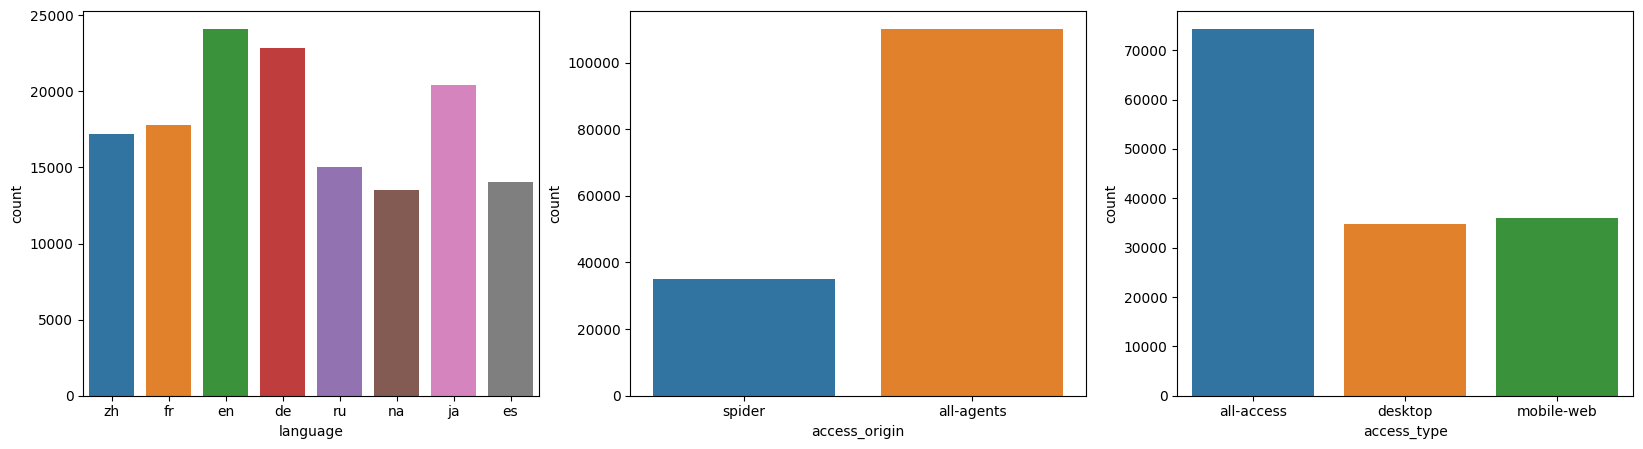

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.countplot(data = df, x='language')
plt.subplot(1,3,2)
sns.countplot(data = df, x='access_origin')
plt.subplot(1,3,3)
sns.countplot(data = df, x='access_type')
plt.show()

> Inference from the above plots
> - Most of the pages are in english language, followed by german and japanese.
> - User agents count is higher as compared to spider. 
> - All-access websites are higher in number as compared to desktop and mobile-web. 

In [11]:
# We have far too many domain names to feature engineer a new variable and conduct analysis.
# Hence, dropping page feature as most of the information is extracted.
df.drop('Page', axis=1, inplace=True)

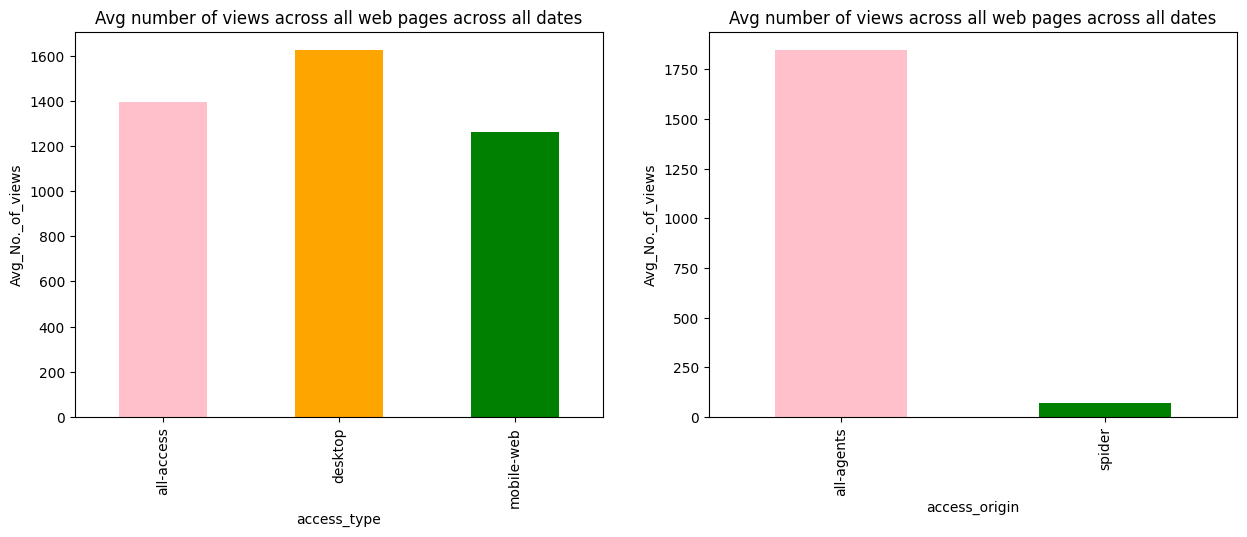

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Avg number of views across all web pages across all dates')
df.groupby('access_type').mean().mean(axis=1).plot(kind='bar', color=['pink', 'orange', 'green'])
plt.ylabel('Avg_No._of_views')
plt.subplot(1,2,2)
plt.title('Avg number of views across all web pages across all dates')
df.groupby('access_origin').mean().mean(axis=1).plot(kind='bar', color=['pink', 'green'])
plt.ylabel('Avg_No._of_views')
plt.show()

> Inference from the above plots
> - Webpages that can only be accessed from desktop has more number of views as compared to other access types on an average across all dates. 
> - Webpages that has access origin as spider has way less as compared to all-agents origin on an average across all dates.

In [13]:
# Getting seperate data frames for individual languages.
df_chinese = df[df.language == 'zh'].iloc[:,3:]
df_french = df[df.language == 'fr'].iloc[:,3:]
df_english = df[df.language == 'en'].iloc[:,3:]
df_german = df[df.language == 'de'].iloc[:,3:]
df_russian = df[df.language == 'ru'].iloc[:,3:]
df_japanese = df[df.language == 'ja'].iloc[:,3:]
df_spanish = df[df.language == 'es'].iloc[:,3:]
df_mixed = df[df.language == 'na'].iloc[:,3:]

###  English language time series

In [14]:
# We do not know if the columns are sorted left to right
df_english = df_english.reindex(sorted(df_english.columns), axis=1)
df_english.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
8357,3.0,4.0,7.0,4.0,4.0,2.0,3.0,7.0,2.0,NaN,...,3.0,1.0,6.0,3.0,1.0,1.0,3.0,3.0,1.0,0.0
8358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2898.0,2676.0,2032.0,2294.0,2074.0,2175.0,2156.0,2302.0,2098.0,1770.0
8359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
8360,2403.0,20136.0,1850.0,1432.0,1351.0,1792.0,1710.0,2039.0,1957.0,1640.0,...,1401.0,1238.0,976.0,810.0,989.0,1332.0,1243.0,1681.0,1303.0,1098.0
8361,982.0,881.0,794.0,979.0,1191.0,1057.0,1184.0,860.0,1259.0,1257.0,...,404.0,344.0,225.0,229.0,335.0,313.0,379.0,393.0,354.0,272.0


In [15]:
df_english.shape

(24111, 550)

In [16]:
# We have data from 1st of july 2015 to end of december which is 18months of data.
df_english.columns[0], df_english.columns[-1]

('2015-07-01', '2016-12-31')

In [17]:
# We have all the dates between '2015-07-01' and '2016-12-31' including both the end dates. 
int(str(pd.to_datetime(df_english.columns[-1]) - pd.to_datetime(df_english.columns[0])).split()[0])+1

550

In [18]:
# Some pages do not have views for some of the dates.
# This might be due to some pages not yet being created for the earlier dates while other pages already existed.
df_english.isna().sum(axis=1)

8357       24
8358      502
8359      392
8360        0
8361        0
         ... 
113946    244
113947      5
113948      4
113949     77
113950      1
Length: 24111, dtype: int64

In [19]:
# Dropping the rows or pages which has missing values in more than 5% of the total columns
nan_indices = df_english.isna().sum(axis=1)[df_english.isna().sum(axis=1)/550 >= 0.05].index
df_english.drop(nan_indices, inplace=True)
df_english.isna().sum(axis=1)[df_english.isna().sum(axis=1)/550 >= 0.05]

Series([], dtype: int64)

In [20]:
# Filling the missing values page wise using the bfill technique. 
df_english.fillna(method='bfill', axis=1, inplace=True)

In [21]:
# Getting the sum of views of all the pages combined for each date.
df_english = df_english.sum().to_frame(name='No_of_views').rename_axis('Date')
df_english = df_english.reset_index()
df_english['Date'] = pd.to_datetime(df_english.Date) # Converting Date column to date_time 

In [22]:
# We donot have any missing values
df_english.isna().sum()

Date           0
No_of_views    0
dtype: int64

#### Train-Test Split

In [23]:
df_english.groupby([df_english.Date.dt.year, df_english.Date.dt.month]).agg({'Date':'first'}).Date.values

array(['2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [24]:
df_english.groupby([df_english.Date.dt.year, df_english.Date.dt.month]).agg({'Date':'last'}).Date.values

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-11-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2016-07-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-31T00:00:00.000000000',
       '2016-11-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [25]:
# Seperating the last 1 month of the data sets to use it for testing. 
# Anything after 2016-12-01 will be kept for testing. 
train_english = df_english.set_index('Date').loc['2015-07-01':'2016-11-30',:].reset_index()
test_english = df_english.set_index('Date').loc['2016-12-01':,:].reset_index()

In [26]:
train_english.shape, test_english.shape

((519, 2), (31, 2))

<AxesSubplot: xlabel='Date'>

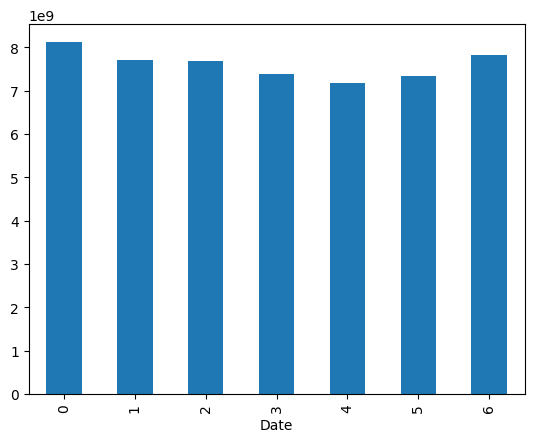

In [27]:
# Comparing total No of views on weekly basis.
# Views on sundays are higher compared to other days of the week. 
train_english.groupby(train_english.Date.dt.dayofweek)['No_of_views'].sum().plot(kind='bar')

In [28]:
# Getting the first date of every month and also the saturdays of every week.
sundays = train_english[(train_english.Date.dt.dayofweek == 0)].Date.values
month_1st_dates =  train_english[(train_english.Date.dt.day == 1)].Date.values

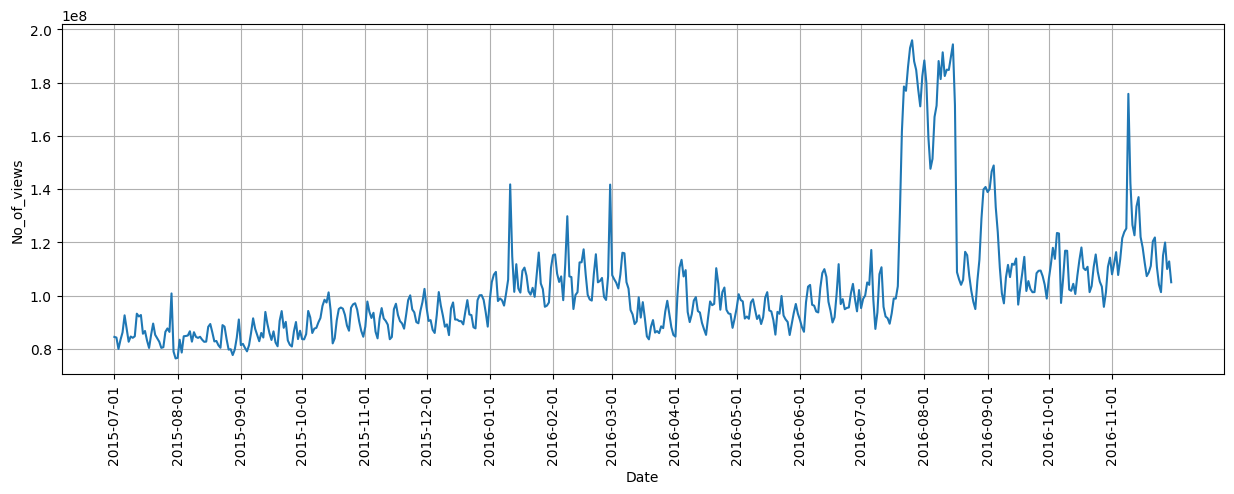

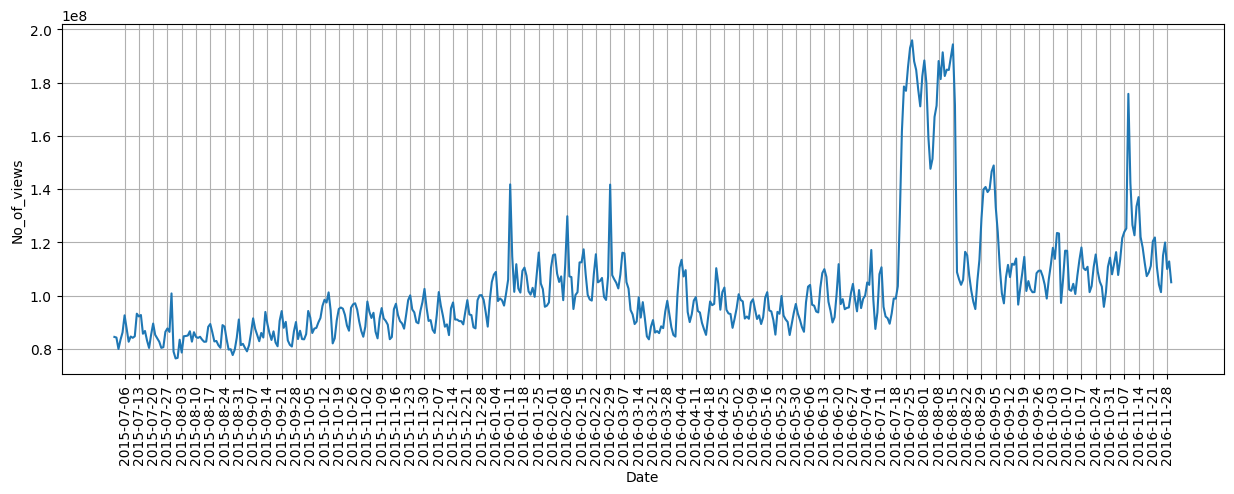

In [29]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(data=train_english, x='Date', y='No_of_views')
plt.xticks(month_1st_dates, rotation='vertical')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.lineplot(data=train_english, x='Date', y='No_of_views')
plt.xticks(sundays, rotation='vertical')
plt.grid()
plt.show()

 - Plot almost seems like the trend is sideways.
 - I can see few outliers which need to be clipped.
 - I can also see 3-4 peeks every month. From the second plot, we can see that almost all the peaks are on saturdays of every week. We have a weekly seasonality in our data. 

#### Stationarity check

> Dickey-Fuller test
> - H0: The time series is non-stationary.
> - HA: The time series is stationary.
> - Let alpha = 0.05 or 5%
> - For H0 to be rejected p-val has to be less than 0.05

In [30]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_english.No_of_views)
# P-val = 0.11 which is is greater than 0.05.
# We fail to reject null hypothesis. Hence, time series is not stationary.

(-2.5023601547529664,
 0.11490112922434526,
 14,
 504,
 {'1%': -3.443391504492468,
  '5%': -2.8672917032172953,
  '10%': -2.5698334393109095},
 17251.707755207037)

#### Time series decomposition

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

english_decomp = seasonal_decompose(train_english.set_index('Date'), two_sided=False)

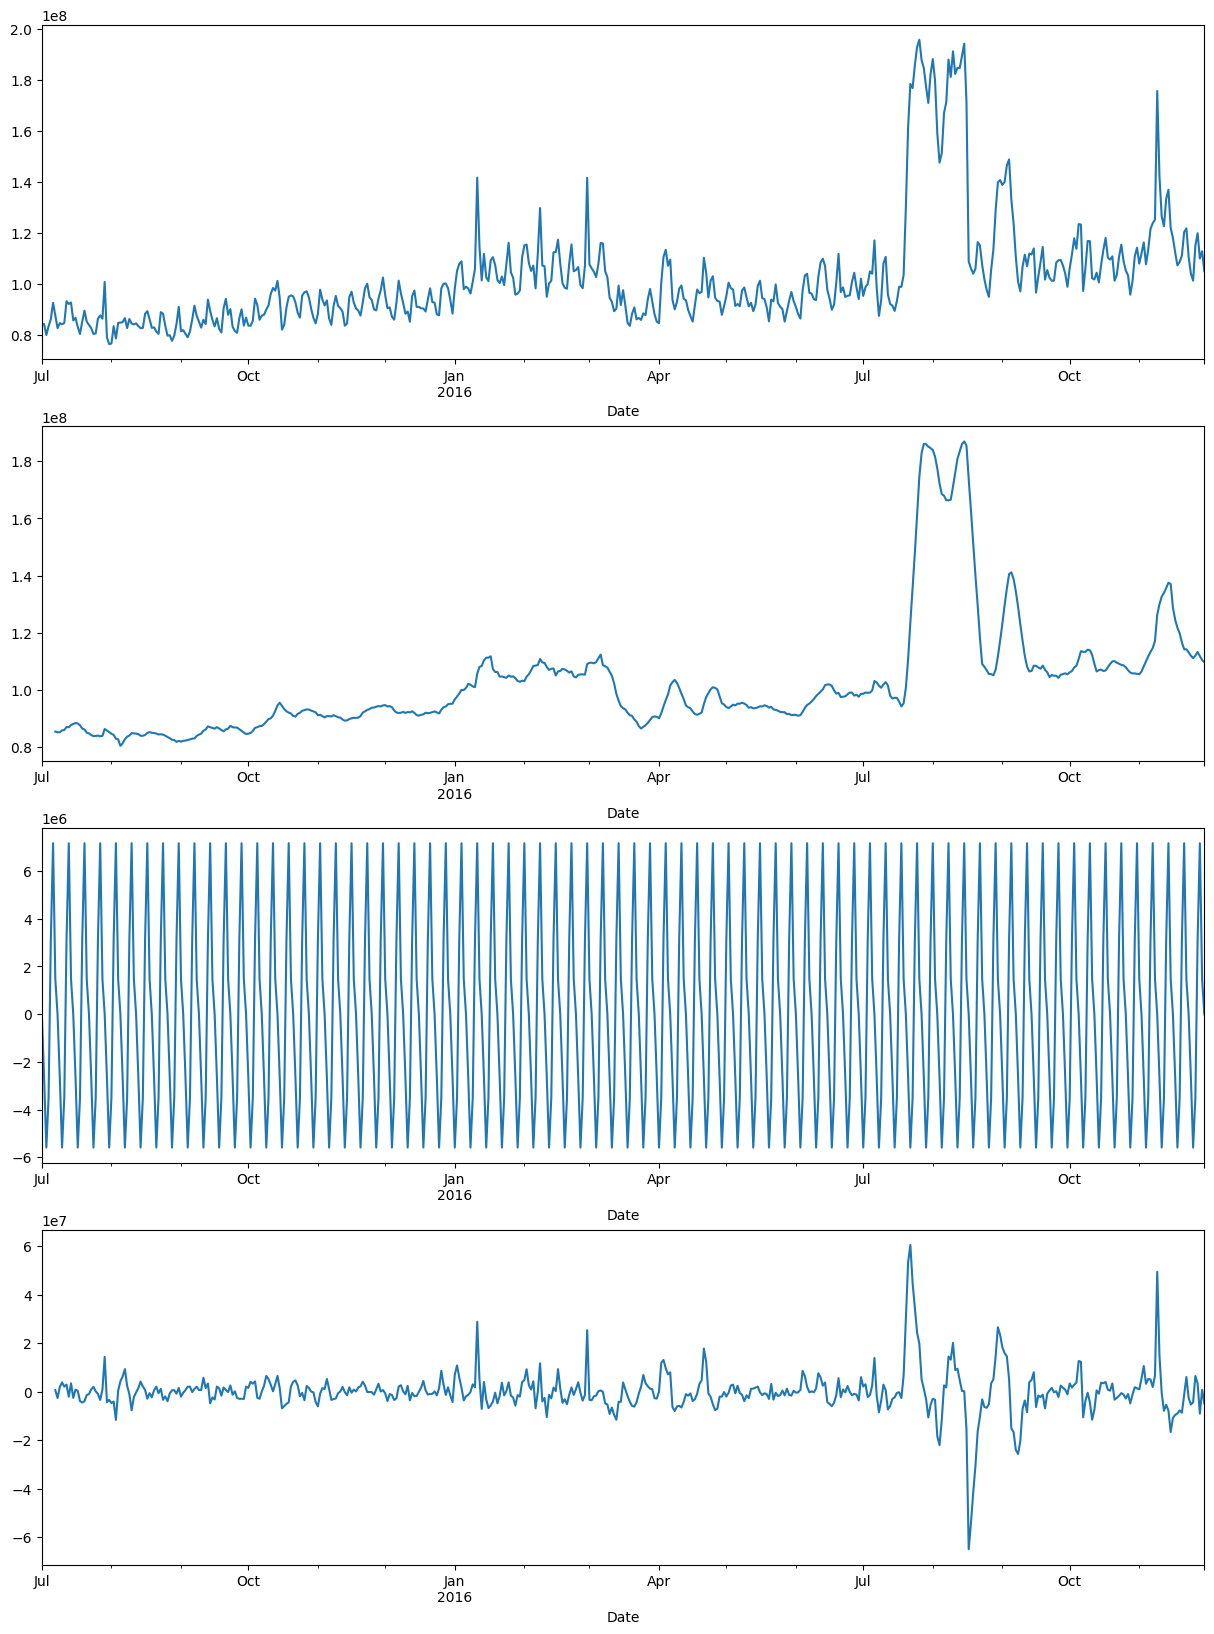

In [32]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
english_decomp.observed.plot()
plt.subplot(4,1,2)
english_decomp.trend.plot()
plt.subplot(4,1,3)
english_decomp.seasonal.plot()
plt.subplot(4,1,4)
english_decomp.resid.plot()
plt.show()

- I do not see increase in variances overtime in my original plot. Hence, I used the additive model to get the decomposition. 
- I can observe a slight upward trend in the trend decomposition plot.
- I can see 4 seasons or peaks in the seasonal decomposition plot. 
- We can use the errors from the decomposition after clipping to build a forecast model as it is stationary (Trend and seasonilty is eliminated).

In [33]:
english_decomp.resid

Date
2015-07-01             NaN
2015-07-02             NaN
2015-07-03             NaN
2015-07-04             NaN
2015-07-05             NaN
                  ...     
2016-11-26    6.530529e+06
2016-11-27    3.468745e+06
2016-11-28   -9.022734e+06
2016-11-29    8.192867e+05
2016-11-30   -4.738162e+06
Name: resid, Length: 519, dtype: float64

In [34]:
from statsmodels.tsa.stattools import adfuller

adfuller(english_decomp.resid[6:])
# P-val = 3.441146312195497e-14 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these residuals to build a model and then finally add seasonality and trend to get back the actual forecast. 

(-8.718250522819737,
 3.441146312195497e-14,
 8,
 504,
 {'1%': -3.443391504492468,
  '5%': -2.8672917032172953,
  '10%': -2.5698334393109095},
 16823.885903672268)

#### Stationary conversion - Detrending

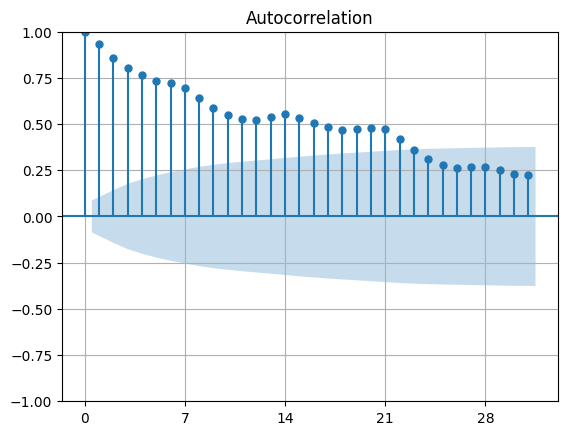

In [35]:
# I can see some good amount of correlation (Coeff > 0.5) until 16 lags.  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_english.No_of_views, lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

In [36]:
# Detrending by diffencing a day's target value with its previous dates for the entire data set (Yt - Yt-1). 
detrend = train_english.No_of_views.diff()
detrend

0             NaN
1       -245041.0
2      -4284127.0
3       3443596.0
4       2770802.0
          ...    
514    13802178.0
515     4830158.0
516    -9939294.0
517     2859471.0
518    -7845936.0
Name: No_of_views, Length: 519, dtype: float64

In [37]:
from statsmodels.tsa.stattools import adfuller

adfuller(detrend[1:])
# P-val = 4.263390340828929e-12 which is less than 0.05.
# We reject null hypothesis confirming time series is stationary.

(-7.897839959411942,
 4.263390340828929e-12,
 13,
 504,
 {'1%': -3.443391504492468,
  '5%': -2.8672917032172953,
  '10%': -2.5698334393109095},
 17222.56979874418)

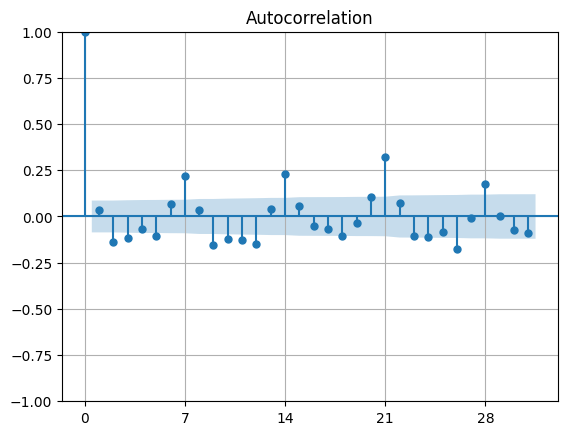

In [38]:
# Data has been detrended as some of the positive correlation has been removed. 
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Stationary conversion - Deseasonalising

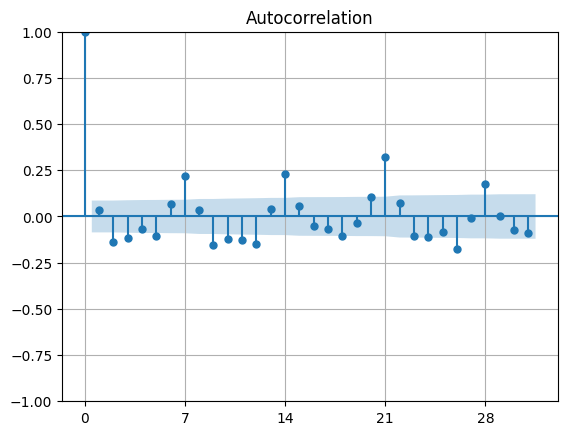

In [39]:
# Eventhough we have detrended the data, a peak still exists every 7 days (m=7). 
# We can take a difference of any date's target with a target of a date which is 7 days prior to the current date(yt - yt-7).
plot_acf(detrend[1:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

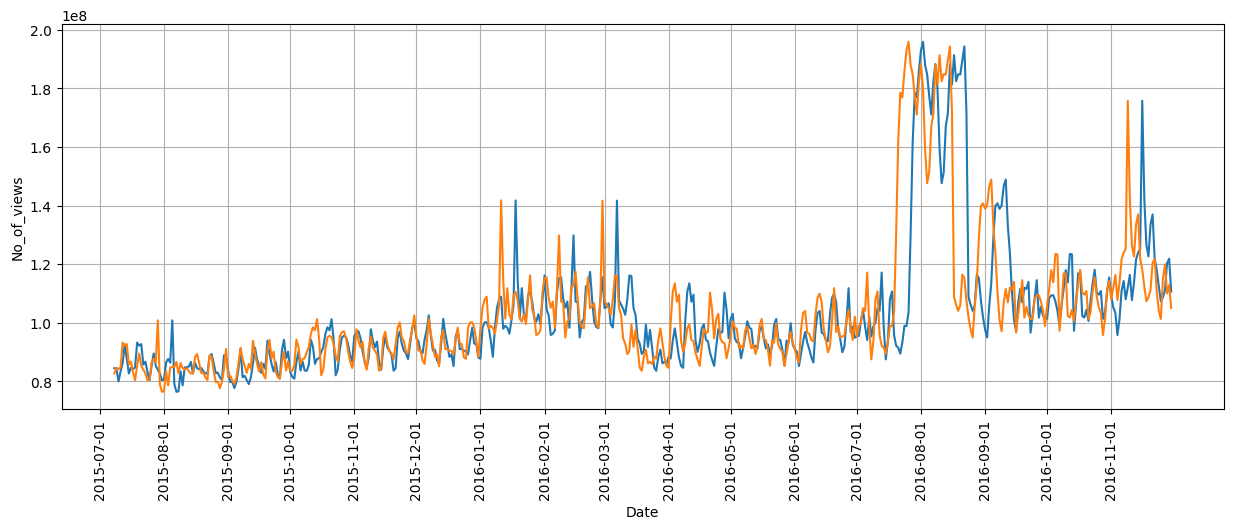

In [40]:
# We can see that almost all the seasonal peaks coincide except those insane outliers around 8th month in 2016.
plt.figure(figsize=(15,5))
sns.lineplot(data=train_english, x=train_english.Date, y=train_english.No_of_views.shift(7))
sns.lineplot(data=train_english, x=train_english.Date, y=train_english.No_of_views[7:])
plt.xticks(month_1st_dates, rotation='vertical')
plt.grid()
plt.show()

In [41]:
# Deseasoning the detrended data
deseason = detrend[1:].diff(7)
deseason.head(10)

1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8     2203746.0
9     3807778.0
10   -2882387.0
Name: No_of_views, dtype: float64

In [42]:
from statsmodels.tsa.stattools import adfuller

adfuller(deseason[7:])
# P-val = 2.451439551152366e-07 which is way less than 0.05.
# We reject null hypothesis confirming time series is stationary.
# We can use these deseasoned and detrended values to build a model and then finally integrate to get back the actual forecast. 

(-5.925326216196231,
 2.451439551152366e-07,
 19,
 491,
 {'1%': -3.4437386290417082,
  '5%': -2.867444458865948,
  '10%': -2.5699148492415413},
 17023.797864859687)

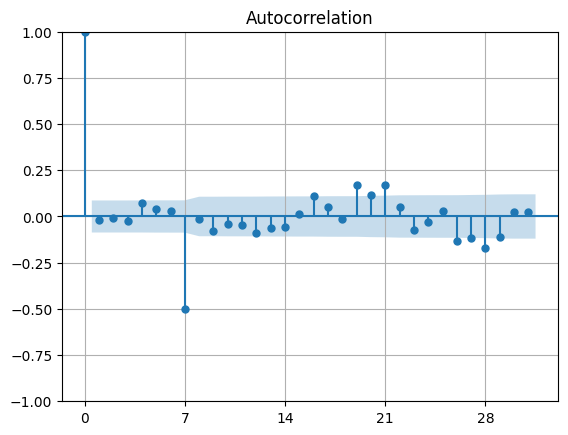

In [43]:
# The data is now detrended and deseasoned.
plot_acf(deseason[7:], lags=31)
plt.xticks(np.arange(0,31,7))
plt.grid()
plt.show()

#### Modelling - ARIMA

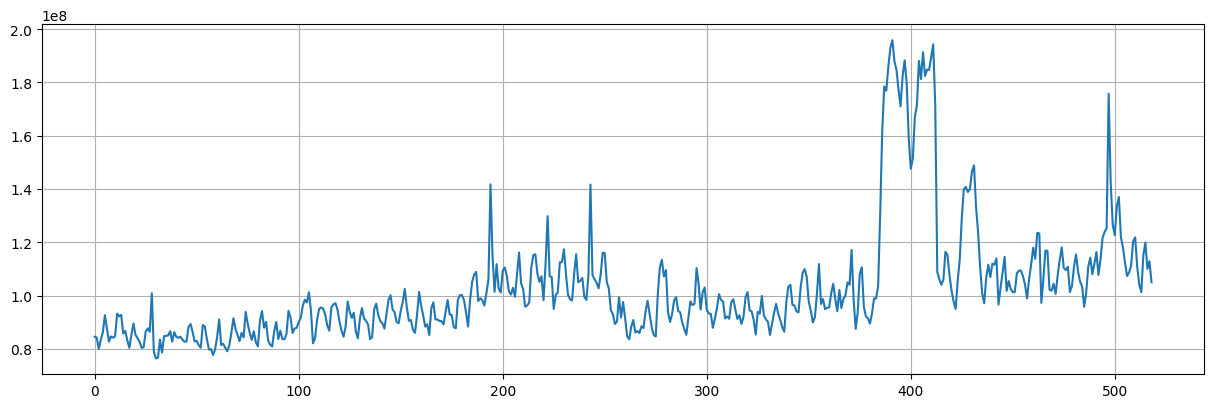

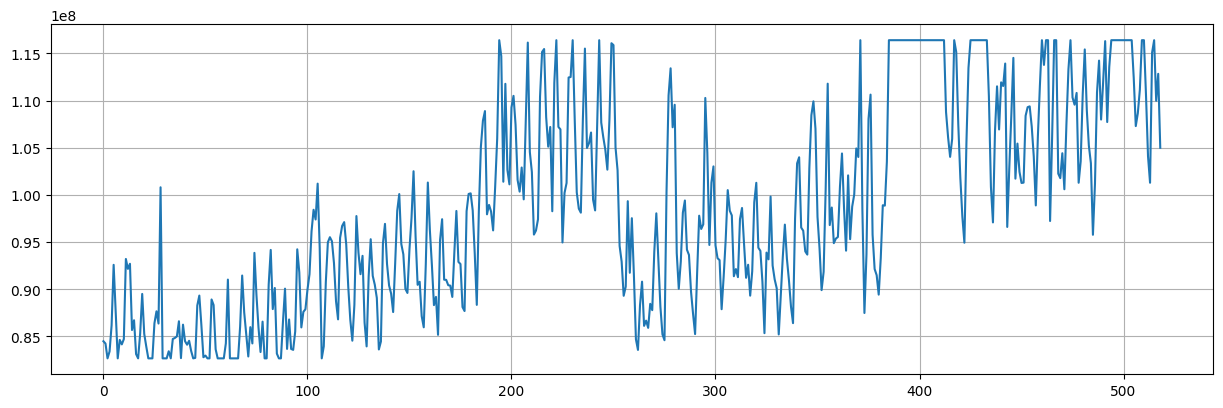

In [44]:
# Clipping the the top 12% and bottom 5% of the values.  
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
train_english.No_of_views.plot(kind='line')
plt.grid()
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
train_english.No_of_views.clip(upper=train_english.No_of_views.quantile(0.88), 
                               lower=train_english.No_of_views.quantile(0.05)).plot(kind='line')
plt.grid()
plt.show()

In [45]:
# Clipping the anamolies or outliers. Anything below 5 percentine and anything above 88 percentile will be clipeed. 
train_english['No_of_views'] = train_english.No_of_views.clip(upper=train_english.No_of_views.quantile(0.88), 
                               lower=train_english.No_of_views.quantile(0.05))

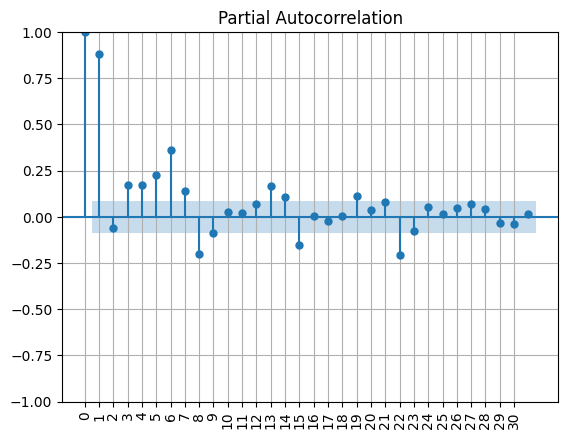

In [46]:
# I can see that some of the lines until 22 lags appear to be a bit significant as per the confidence intervals. 
# I will take only the first 6 or 7 lags as hyperparameters p.
plot_pacf(train_english.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='vertical')
plt.grid()
plt.show()

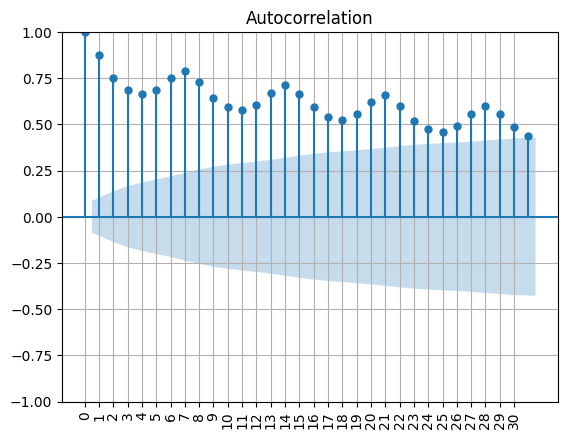

In [47]:
# I can see that some of the lines until 23 lags appear to be a bit significant as per the confidence intervals. 
#  Due to seasonality, it is going up and down and extending to 23. I will take only the first 6 lags as q. 
plot_acf(train_english.No_of_views, lags=31)
plt.xticks(np.arange(0,31,1), rotation='vertical')
plt.grid()
plt.show()

In [48]:
# Training the ARIMA model by keeping detrending or trend diff value as 1 
# AD fuller test confirmed a single trend diff made data stationary
# For AR and MA parameters p and q, I will be running a grid search to get the best possible params and MAPE. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'p':np.arange(1,7), 'q':np.arange(1,7)}))

arima_mapes = []

for i in range(len(param_grid)):
    english_arima = SARIMAX(train_english.No_of_views, order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
    arima_mapes.append(mean_absolute_percentage_error(test_english.No_of_views, english_arima.forecast(len(test_english)))*100)

In [49]:
# For order = (3,1,3), I could get the MAPE as 6.6%. 
param_grid[np.argmin(np.array(arima_mapes))], min(arima_mapes)

({'p': 3, 'q': 3}, 6.66861385157556)

> -  Best MAPE with ARIMAX for test set is 6.6%

In [50]:
# Retraining the model with the best params for the entire train set.
english_arima = SARIMAX(train_english.No_of_views, order=(3,1,3)).fit(disp=False)

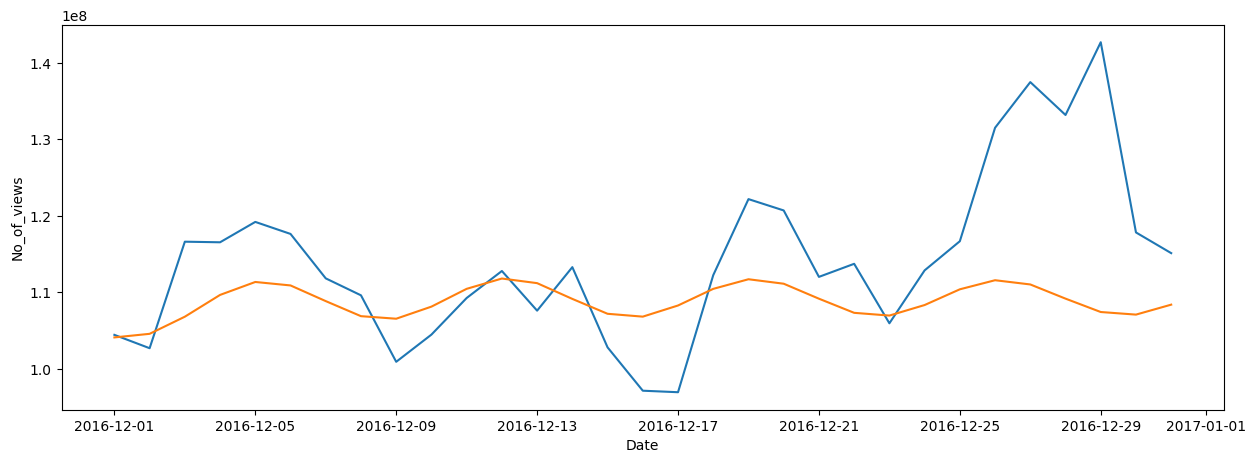

In [51]:
# It did a fine job but we still have seasonality and exogenous variable to consider. 
# We might be able to decrease our MAPE further. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_english.Date, y=test_english.No_of_views)
sns.lineplot(x=test_english.Date, y=english_arima.forecast(len(test_english)).values)
plt.show()

#### Modelling - SARIMAX

In [52]:
exog = pd.read_csv(r'C:\Users\Home\csv_files\Exog_Campaign_eng').rename({'Exog':'Campaign'}, axis=1)
exog.head()

,Campaign
0,0
1,0
2,0
3,0
4,0


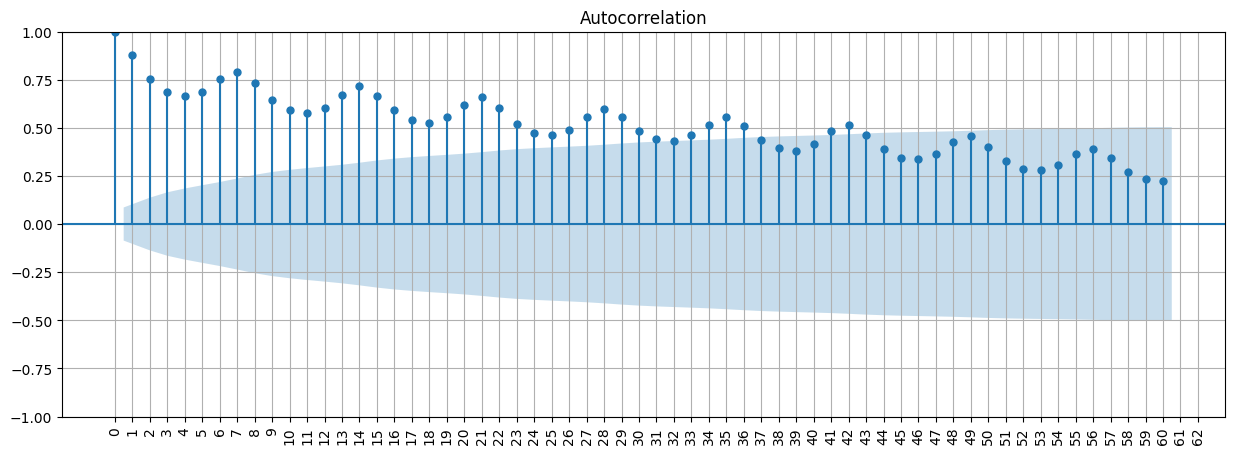

In [53]:
# Some of the seasonal lines (Multiples of 7) appear to be bit significant until 42 as per the confidence intervals. 
# From this plot, I will take the first 6 seasonality lags as hyperparameters for Q. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train_english.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='vertical')
plt.grid()
plt.show()

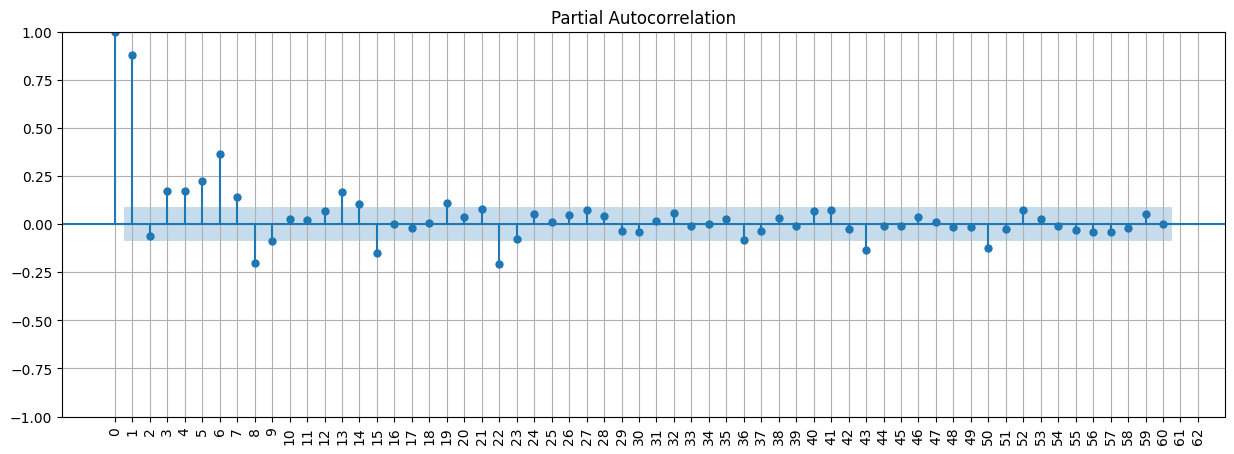

In [54]:
# From this plot, I will take only the first 3 seasonality lags as hyperparameters for P. 
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train_english.No_of_views, lags=60, ax=ax)
plt.xticks(np.arange(0,63,1), rotation='vertical')
plt.grid()
plt.show()

In [55]:
# Training the SARIMAX model by keeping detrending or trend diff and seasonal diff values as 1. 
# For AR and MA parameters p and q, taking both as 3 as per arima hyperparameter tuning. 
# For AR-Seasonality and MA-seasonality, finding the best combination using grid search.
# m = 7 (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

param_grid = list(ParameterGrid({'P':[1, 2, 3], 'Q':[1,2,3,4,5,6]}))

sarimax_mapes = []

for i in range(len(param_grid)):
    english_sarimax = SARIMAX(train_english.No_of_views,
                            exog = exog.Campaign[:len(train_english)], 
                            order=(3, 1, 3), 
                            seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)
    
    test_forecast = english_sarimax.forecast(steps = len(test_english), 
                                             exog = exog.Campaign[len(train_english):].reset_index(drop=True))
    
    sarimax_mapes.append(mean_absolute_percentage_error(test_english.No_of_views, test_forecast)*100)

In [56]:
# For params (3,1,3) and (2,1,1,7), I could get an MAPE as 5.98% which is not an improved score as compared to ARIMA. 
param_grid[np.argmin(np.array(sarimax_mapes))], min(sarimax_mapes)

({'P': 2, 'Q': 1}, 7.1874946175912795)

> -  Best MAPE with SARIMAX for test set is 7.18%

In [57]:
# Retraining the sarimax model with the best params
english_sarimax = SARIMAX(train_english.No_of_views, 
                          order=(3,1,3), 
                          seasonality_order=(2, 1, 1, 7), 
                          exog = exog.Campaign[:len(train_english)]).fit(disp=False)
test_forecast = english_sarimax.forecast(steps = len(test_english), 
                                             exog = exog.Campaign[len(train_english):].reset_index(drop=True))

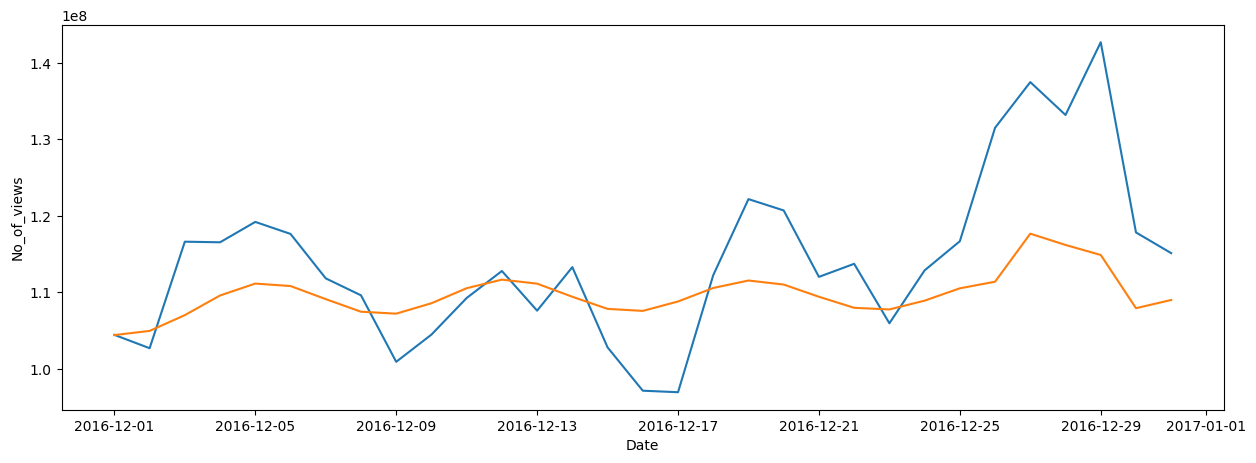

In [58]:
plt.figure(figsize=(15,5))
sns.lineplot(x=test_english.Date, y=test_english.No_of_views)
sns.lineplot(x=test_english.Date, y=test_forecast.values)
plt.show()

#### Forecasting with Prophet

In [59]:
# Adding Exogenous variable campaign to train data frame
train_english['Campaign'] = exog['Campaign'][:train_english.shape[0]]
train_english.head()

,Date,No_of_views,Campaign
0,2015-07-01,84482673.0,0
1,2015-07-02,84237632.0,0
2,2015-07-03,82666451.4,0
3,2015-07-04,83397101.0,0
4,2015-07-05,86167903.0,0


In [60]:
# Training Prophet model with weekly seasonality and confidence interval of 95%. 
from prophet import Prophet

english_prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
Prophet.add_regressor(english_prophet, 'Campaign')
english_prophet.fit(train_english.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
future = english_prophet.make_future_dataframe(periods=len(test_english),freq="D")
future['Campaign'] = exog['Campaign']
forecast = english_prophet.predict(future)

19:21:11 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing


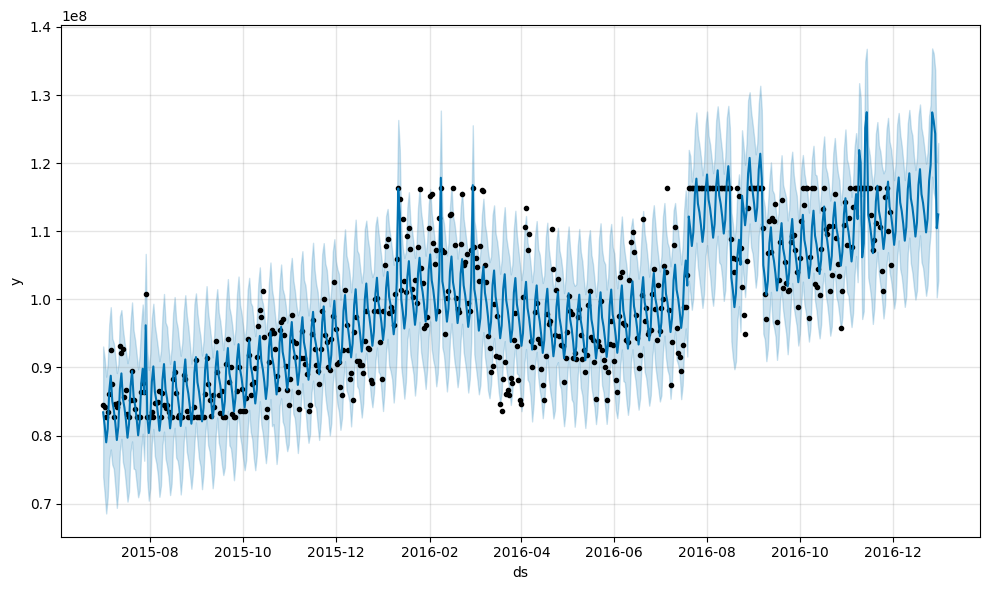

In [61]:
english_prophet.plot(forecast)
plt.show()

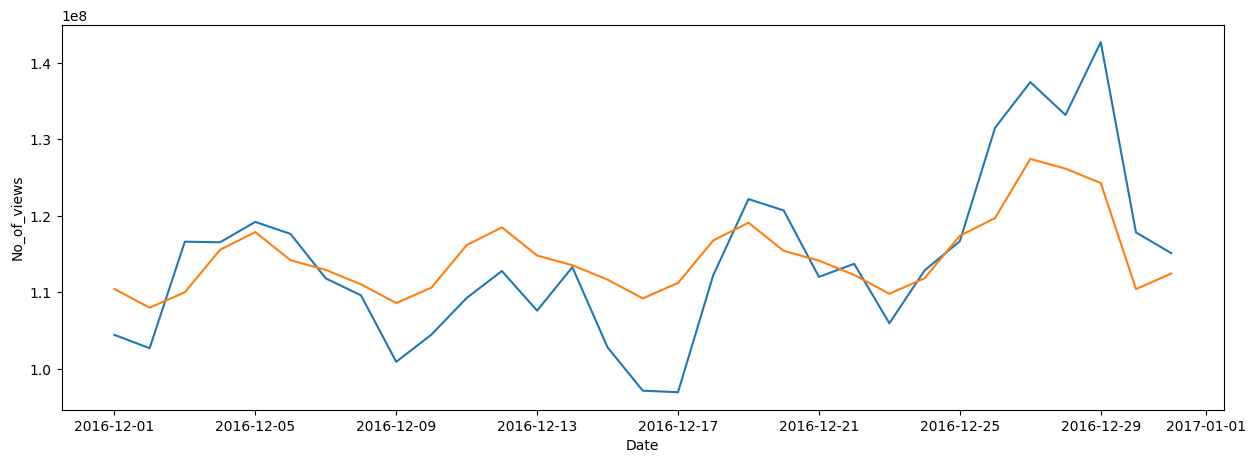

In [62]:
# The peaks fit and align better than SARIMAX model. No hyperparameter tuning was also required. 
plt.figure(figsize=(15,5))
sns.lineplot(x=test_english.Date, y=test_english.No_of_views)
sns.lineplot(x=test_english.Date, y=forecast.iloc[len(train_english):, :].yhat.values)
plt.show()

In [63]:
# We got 4.95% MAPE which is better than SARIMAX.
mean_absolute_percentage_error(test_english.No_of_views, forecast.iloc[len(train_english):, :].yhat)*100

4.959276365430559

### Forecasting Pipeline

In [74]:
# Creating a pipeline to forecast for rest of the language pages. 
def create_forecast_model(data_frame):
    
    # Creating a deepcopy of the df. 
    from copy import deepcopy
        
    df = deepcopy(data_frame)
    
    # Reindexing the df to suit the requirements.
    df = df.reindex(sorted(df.columns), axis=1)
    
    # Dropping the rows or pages which has missing values in more than 5% of the total columns
    nan_indices = df.isna().sum(axis=1)[df.isna().sum(axis=1)/550 >= 0.05].index
    df.drop(nan_indices, inplace=True)
    
    # Filling the missing values page wise using the bfill technique. 
    df.fillna(method='bfill', axis=1, inplace=True)
    
    # Getting the sum of views of all the pages combined for each date.
    df = df.sum().to_frame(name='No_of_views').rename_axis('Date')
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df.Date) # Converting Date column to date_time.
    
    # Seperating the last 1 month of the data sets to use it for testing. 
    train = df.set_index('Date').loc['2015-07-01':'2016-11-30',:].reset_index()
    test = df.set_index('Date').loc['2016-12-01':,:].reset_index()
    
    # Clipping the outliers. Considering the top and bottom 5% as outliers
    train['No_of_views'] = train.No_of_views.clip(upper=train.No_of_views.quantile(0.95), 
                               lower=train.No_of_views.quantile(0.05))
    
    # Importing the libraries
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.model_selection import ParameterGrid

    # ARIMA Model
    param_grid = list(ParameterGrid({'p':np.arange(1,7), 'q':np.arange(1,7)}))

    arima_mapes = []
    
    # Hyper parameter tuning ARIMA model.
    for i in range(len(param_grid)):
        arima = SARIMAX(train.No_of_views, order=(param_grid[i]['p'], 1, param_grid[i]['q'])).fit(disp=False)
        arima_forecast = arima.forecast(len(test))
        arima_mapes.append(mean_absolute_percentage_error(test.No_of_views, arima_forecast)*100)
        
    
    p, q = param_grid[np.argmin(np.array(arima_mapes))]['p'], param_grid[np.argmin(np.array(arima_mapes))]['q']
    best_arima_mape = min(arima_mapes)
    
    # Retraining the ARIMA model with the best params for the entire train set.
    best_arima_model = SARIMAX(train.No_of_views, order=(p,1,q)).fit(disp=False)
      
    # SARIMA Model
    param_grid = list(ParameterGrid({'P':[1, 2], 'Q':[1,2,3,4]}))

    sarima_mapes = []
    
    # Hyper parameter tuning SARIMA model.
    for i in range(len(param_grid)):
        sarima = SARIMAX(train.No_of_views, 
                                order=(p, 1, q), 
                                seasonal_order=(param_grid[i]['P'], 1, param_grid[i]['Q'], 7)).fit(disp=False)

        sarima_forecast = sarima.forecast(steps = len(test))

        sarima_mapes.append(mean_absolute_percentage_error(test.No_of_views, sarima_forecast)*100)
    
    
    P, Q = param_grid[np.argmin(np.array(sarima_mapes))]['P'], param_grid[np.argmin(np.array(sarima_mapes))]['Q']
    best_sarima_mape = min(sarima_mapes)
    
    # Retraining the sarimax model with the best params
    best_sarima_model = SARIMAX(train.No_of_views, 
                          order=(p,1,q), 
                          seasonality_order=(P, 1, Q, 7)).fit(disp=False)
    
    # Training Prophet model with weekly seasonality and confidence interval of 95%. 
    from prophet import Prophet

    prophet = Prophet(weekly_seasonality=True, interval_width=0.95)
    prophet.fit(train.rename({'Date':'ds', 'No_of_views':'y'}, axis=1))
    future = prophet.make_future_dataframe(periods=len(test),freq="D")
    forecast = prophet.predict(future)
    
    best_prophet_mape = mean_absolute_percentage_error(test.No_of_views, forecast.iloc[len(train):, :].yhat)*100
    
    all_best_scores = {'arima':best_arima_mape, 'sarima':best_sarima_mape, 'prophet':best_prophet_mape}
    
    all_best_models = {'arima':best_arima_model, 'sarima':best_sarima_model, 'prophet':prophet}
    
    best_score_overall = min(all_best_scores.values())
    
    best_model_overall = all_best_models[min(all_best_scores, key=all_best_scores.get)]
    
    return best_model_overall, best_score_overall, all_best_scores, all_best_models

In [76]:
# Creating models for all the leftover languages

chinese_best_model, chinese_best_score, chinese_scores, chinese_models = create_forecast_model(df_chinese)
french_best_model, french_best_score, french_scores, french_models = create_forecast_model(df_french)
german_best_model, german_best_score, german_scores, german_models= create_forecast_model(df_german)
japanese_best_model, japanese_best_score, japanese_scores, japanese_models= create_forecast_model(df_japanese)
mixed_best_model, mixed_best_score, mixed_scores, mixed_models= create_forecast_model(df_mixed)
russian_best_model, russian_best_score, russian_scores, russian_models= create_forecast_model(df_russian)
spanish_best_model, spanish_best_score, spanish_scores, spanish_models= create_forecast_model(df_spanish)

20:38:38 - cmdstanpy - INFO - Chain [1] start processing
20:38:38 - cmdstanpy - INFO - Chain [1] done processing
20:40:04 - cmdstanpy - INFO - Chain [1] start processing
20:40:04 - cmdstanpy - INFO - Chain [1] done processing
20:41:34 - cmdstanpy - INFO - Chain [1] start processing
20:41:34 - cmdstanpy - INFO - Chain [1] done processing
20:42:31 - cmdstanpy - INFO - Chain [1] start processing
20:42:31 - cmdstanpy - INFO - Chain [1] done processing
20:43:56 - cmdstanpy - INFO - Chain [1] start processing
20:43:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:40 - cmdstanpy - INFO - Chain [1] start processing
20:45:40 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
# Among all the languages, best MAPE score of 3.3% was found on the chinese model.

mapes_scores=[chinese_best_score, french_best_score, german_best_score, japanese_best_score, mixed_best_score, 
              russian_best_score, spanish_best_score]

np.argmin(mapes_scores), min(mapes_scores)

(0, 3.3443859197049814)

### Pickling for Deployment

In [78]:
# Seperating the sarima and prophet models. Will not be using the english model as we do not have any information on the future
# Exogenous variable. 
all_models = [chinese_best_model, french_best_model, german_best_model, spanish_best_model, russian_best_model, 
              japanese_best_model]

names = ['chinese.pkl', 'french.pkl', 'german.pkl', 'spanish.pkl', 'russian.pkl', 'japanese.pkl']

In [79]:
# Dumping all the models in the git folder. 
import pickle

for i in range(len(all_models)):
    pickle.dump(all_models[i], open(names[i], 'wb'))